# Notebook pour projet DCD

## Roadmap

1 - Import all metrics in an array of shape *metrics* × *species* × *values*

2 - Cluster *species* × *values* for each metric then compare to orthologs

In [1]:
import sklearn.cluster
import matplotlib.pyplot as plt
import numpy
import pandas
import glob
import seaborn as sns

## 1 - Import

In [2]:
arraylist = list()
metrics_list = glob.glob("Metrics/*.tsv")
for filename in metrics_list:
    csv_df = pandas.read_csv(filename, delimiter = "\t", index_col=0)
    arraylist.append(csv_df)

In [3]:
np_list = list()
for array in arraylist:
    shape = array.shape
    array_nonacol = array.dropna(axis=0, thresh = shape[1] - 10000)
    array_nona = array_nonacol.dropna(axis = 1)
    np_list.append(array_nona)

In [4]:
# we need all rows and columns names that are not common to all the arrays
columns = set(np_list[0].columns)
rows = set(np_list[0].index)
cols_todel = list()
rows_todel = list()

for array in np_list: # first get all common elements
    rows = rows.intersection(set(array.index))
    columns = columns.intersection(set(array.columns))

for array in np_list: # then get the diff for each array
    rows_todel.append(set(array.index) - rows)
    cols_todel.append(set(array.columns) - columns)

In [5]:
stackable_arrays = list()
for array, rows, cols in zip(np_list, rows_todel, cols_todel):
    temp = array.drop(index=rows)
    stackable_arrays.append(temp.drop(columns = cols))

In [6]:
stacked_arrays = numpy.stack([i.to_numpy() for i in stackable_arrays])
stacked_arrays.shape

(4, 57, 597)

## 2 - Cluster for each metric then compare to orthologs

### Cluster

In [7]:
# from metrics : species : genes to genes : metrics
to_merge = list()
for i in range(stacked_arrays.shape[1]):
    to_merge.append(stacked_arrays[:,i,:].transpose())
genes_x_metrics = numpy.concatenate(to_merge)
genes_x_metrics.shape

(34029, 4)

In [8]:
sc = sklearn.cluster.OPTICS(min_samples=57).fit(genes_x_metrics)
max(sc.labels_)

34

### Compare

Create a count cluster : labels

In [9]:
labels = list()
for i in range(stacked_arrays.shape[1]):
    labels += list(stackable_arrays[0].columns)

In [10]:
counts_by_labels = dict()
for cluster, label in zip(sc.labels_, labels):
    if cluster not in counts_by_labels:
        counts_by_labels[cluster]=dict()
    if label not in counts_by_labels[cluster]:
        counts_by_labels[cluster][label]=0
    counts_by_labels[cluster][label] += 1

Then graph it as a stacked barplot

In [11]:
data = {"name": list(), "parent": list(), "value": list()}
for cluster in counts_by_labels:
    if not cluster == -1:
        for label in counts_by_labels[cluster]:
            data["name"].append(label)
            data["parent"].append(cluster)
            data["value"].append(counts_by_labels[cluster][label])

In [12]:
import plotly.express as px
# parent is cluster
# character is ortholog
# values is count character by cluster
fig = px.bar(data, x="parent", y="value", color="name")
fig.show(renderer="browser")

Now let's analyse clusters : are they determined more by species or by orthology ? Since we have 57 species and 34 clusters it mays indicate something ; but then each group should contain a unique copy of each ortholog gene.

In [13]:
cluster_content = list()
for cluster in counts_by_labels:
    cluster_content.append((cluster,sum([counts_by_labels[cluster][i] for i in counts_by_labels[cluster]])/len([counts_by_labels[cluster][i] for i in counts_by_labels[cluster]])))
cluster_content

[(-1, 48.553691275167786),
 (26, 1.446808510638298),
 (13, 6.098522167487685),
 (2, 1.2361111111111112),
 (27, 1.4086021505376345),
 (11, 1.6296296296296295),
 (24, 1.6349206349206349),
 (3, 1.6026490066225165),
 (28, 1.2903225806451613),
 (10, 1.1403508771929824),
 (34, 1.9189189189189189),
 (19, 1.2307692307692308),
 (29, 1.353846153846154),
 (14, 1.3235294117647058),
 (15, 1.1904761904761905),
 (8, 1.381679389312977),
 (12, 1.2191780821917808),
 (6, 1.2903225806451613),
 (5, 1.2584269662921348),
 (33, 1.6829268292682926),
 (1, 1.6311475409836065),
 (31, 1.5957446808510638),
 (23, 1.2222222222222223),
 (17, 1.3736263736263736),
 (30, 1.7849462365591398),
 (25, 1.34375),
 (22, 1.1636363636363636),
 (0, 1.368421052631579),
 (18, 1.2266666666666666),
 (32, 1.4482758620689655),
 (20, 1.2463768115942029),
 (7, 1.2424242424242424),
 (4, 1.2253521126760563),
 (9, 1.1694915254237288),
 (16, 1.0923076923076922),
 (21, 1.3243243243243243)]

Average value is ~ 1 ; it confirm our hypothesis that the metrics are determined by species and so the clusters reflect the species. But why do we have the 13th cluster ?

In [14]:
sorted([[i, counts_by_labels[13][i]] for i in counts_by_labels[13]], key = lambda x: x[1])

[['2961', 1],
 ['79886', 1],
 ['56913', 1],
 ['506', 1],
 ['27190', 1],
 ['23234', 1],
 ['8464', 1],
 ['7172', 1],
 ['941', 1],
 ['8813', 1],
 ['25949', 1],
 ['29088', 1],
 ['8883', 1],
 ['94103', 1],
 ['79035', 1],
 ['51026', 1],
 ['84275', 1],
 ['283576', 1],
 ['874', 1],
 ['64757', 1],
 ['286451', 1],
 ['10577', 1],
 ['5129', 1],
 ['6750', 1],
 ['79642', 1],
 ['9113', 1],
 ['843', 1],
 ['80267', 1],
 ['25897', 1],
 ['126767', 1],
 ['11264', 1],
 ['26578', 1],
 ['7389', 1],
 ['83464', 1],
 ['11015', 1],
 ['51637', 1],
 ['890', 1],
 ['58527', 1],
 ['401546', 1],
 ['4548', 1],
 ['8539', 1],
 ['64841', 1],
 ['9470', 1],
 ['51804', 1],
 ['171177', 1],
 ['6697', 1],
 ['1143', 1],
 ['55584', 1],
 ['5648', 1],
 ['6425', 1],
 ['164284', 1],
 ['79768', 1],
 ['53836', 1],
 ['7374', 1],
 ['54757', 1],
 ['91975', 1],
 ['144577', 1],
 ['55180', 1],
 ['92591', 1],
 ['57168', 1],
 ['79689', 1],
 ['55734', 1],
 ['6001', 1],
 ['2302', 1],
 ['60386', 1],
 ['55248', 1],
 ['2643', 1],
 ['55176', 1],
 ['

Two orthologs groups are almost full (57 and 55) ; additionnal info on these genes tell us that they are associated one with immune response and the other with cell cycle. These are essential functions which implies selective pressure and limited evolution.
This may explain that genes cluster together. However, we need to check if other genes in other clusters have a similar profile.

## Is evolution at the origin of the previous clustering ?

### Align genes from cluster 16 and cluster 13 and compare conservation

In [15]:
counts_by_labels[16]

{'8817': 1,
 '51096': 1,
 '55726': 2,
 '8508': 1,
 '9147': 1,
 '55127': 1,
 '55929': 1,
 '5634': 1,
 '286451': 1,
 '55180': 1,
 '221656': 1,
 '57540': 1,
 '51208': 1,
 '134510': 1,
 '84275': 1,
 '9271': 2,
 '7378': 2,
 '83543': 1,
 '6565': 1,
 '257629': 2,
 '203228': 1,
 '8417': 1,
 '23732': 3,
 '92906': 1,
 '6483': 1,
 '83931': 1,
 '8602': 1,
 '80006': 1,
 '64431': 1,
 '8315': 1,
 '51077': 1,
 '2802': 1,
 '3274': 1,
 '64421': 1,
 '482': 1,
 '8323': 1,
 '6006': 1,
 '8539': 1,
 '9470': 1,
 '10594': 1,
 '64577': 1,
 '58478': 1,
 '3290': 1,
 '80025': 1,
 '4641': 1,
 '145389': 1,
 '64375': 1,
 '201294': 1,
 '54491': 1,
 '64428': 1,
 '81556': 1,
 '3363': 1,
 '27190': 1,
 '64793': 1,
 '253943': 1,
 '25978': 1,
 '1315': 1,
 '57515': 1,
 '9125': 1,
 '25851': 1,
 '55248': 1,
 '9497': 1,
 '26118': 1,
 '941': 1,
 '160897': 1}

In [ ]:
#TODO prévoir une analyse d'alignements pour vérifier que les gènes du cluster 16 sont bien moins conservés que ceux du cluster 13

### Compare GC3 / GC

Another way to test it is to compare clustering using rates at the 3rd position of the codon (synonymous pos, not selected) with clustering using rates for the gene.

In [36]:
conserved = pandas.read_csv("Metrics/metrics_GC3_exons.tsv", delimiter = "\t", index_col=0)
random = pandas.read_csv("metrics_GC_gene.tsv", delimiter = "\t", index_col = 0)
introns = pandas.read_csv("Metrics/metrics_intron_size.tsv", delimiter = "\t", index_col=0) # we add this array to have two dimensions

In [39]:
np_list = list()
for array in conserved, random, introns:
    shape = array.shape
    array_nonacol = array.dropna(axis=0, thresh = shape[1] - 10000)
    array_nona = array_nonacol.dropna(axis = 1)
    np_list.append(array_nona)

In [40]:
# we need all rows and columns names that are not common to all the arrays
columns = set(np_list[0].columns)
rows = set(np_list[0].index)
cols_todel = list()
rows_todel = list()

for array in np_list: # first get all common elements
    rows = rows.intersection(set(array.index))
    columns = columns.intersection(set(array.columns))

for array in np_list: # then get the diff for each array
    rows_todel.append(set(array.index) - rows)
    cols_todel.append(set(array.columns) - columns)

In [41]:
stackable_arrays = list()
for array, rows, cols in zip(np_list, rows_todel, cols_todel):
    temp = array.drop(index=rows)
    stackable_arrays.append(temp.drop(columns = cols))

In [42]:
stacked_arrays = numpy.stack([i.to_numpy() for i in stackable_arrays])
stacked_arrays.shape

(3, 57, 609)

In [64]:
sc = sklearn.cluster.OPTICS(min_samples=57).fit(stacked_arrays[0,-1,:].reshape(-1, 1))
cluster_conserved = list(sc.labels_)
sc = sklearn.cluster.OPTICS(min_samples=57).fit(stacked_arrays[1,-1,:].reshape(-1, 1))
cluster_random = list(sc.labels_)

In [80]:
to_write = [(i, j, gene) for i, j, gene in zip(cluster_conserved, cluster_random, list(conserved.columns)) if i != j]
export = open("results.txt", "w")
export.write(str([i[2] for i in to_write]))
export.close()

We have 194 out of 609 genes that are clustered differently. Let's check who they are.

In [71]:
list(conserved.columns)

['149685',
 '8992',
 '55255',
 '8399',
 '4233',
 '51510',
 '11214',
 '51726',
 '4649',
 '4201',
 '729857',
 '7837',
 '54766',
 '951',
 '51334',
 '6745',
 '25874',
 '1612',
 '8877',
 '8347',
 '7174',
 '23491',
 '563',
 '26248',
 '5433',
 '653319',
 '60437',
 '51281',
 '5297',
 '57622',
 '55531',
 '3975',
 '441549',
 '1234',
 '29968',
 '60676',
 '7739',
 '9537',
 '4920',
 '2986',
 '7464',
 '22887',
 '9379',
 '10478',
 '145270',
 '139562',
 '26275',
 '57573',
 '107984351',
 '169200',
 '51050',
 '1',
 '4101',
 '203611',
 '8807',
 '1649',
 '11096',
 '57035',
 '728082',
 '286527',
 '80222',
 '23545',
 '23350',
 '83942',
 '84958',
 '89958',
 '196441',
 '221662',
 '642517',
 '286046',
 '80262',
 '26011',
 '222611',
 '80194',
 '53841',
 '114771',
 '56301',
 '162494',
 '134145',
 '65983',
 '221477',
 '1902',
 '2935',
 '2982',
 '245711',
 '4922',
 '644150',
 '9262',
 '2568',
 '80173',
 '170685',
 '2938',
 '55024',
 '388722',
 '10158',
 '4437',
 '10742',
 '59340',
 '55723',
 '3982',
 '9334',
 '133

In [57]:
sc.labels_

array([-1, -1, -1, -1, -1, -1, -1,  0,  0, -1, -1,  0, -1, -1,  0, -1, -1,
       -1,  0, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        0, -1, -1,  0, -1, -1, -1, -1, -1,  0, -1, -1,  0,  0, -1, -1, -1,
        0, -1, -1, -1, -1,  0,  0,  0, -1, -1, -1,  0, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0, -1,
        0, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1,
       -1,  0, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1,  0,  0, -1, -1,  0, -1, -1, -1,  0,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1,  0, -1,  0,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0, -1,  0,
       -1, -1, -1, -1,  0, -1, -1,  0, -1,  0, -1, -1,  0, -1, -1, -1, -1,
       -1, -1, -1, -1, -1,  0, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1,  0, -1, -1, -1, -1,  0,  0, -1,  0, -1, -1, -1,  0, -1,
       -1, -1, -1, -1,  0

In [21]:
#array_graph = numpy.stack(([i.split("/")[1].split(".")[0] for i in metrics_list], sc.labels_))
array_graph = numpy.stack((stackable_arrays[0].columns.to_numpy(), sc.labels_))
array_graph

ValueError: all input arrays must have the same shape

In [48]:
df_graph = pandas.DataFrame(array_graph.transpose(), columns = ["File", "Cluster"])
df_graph["Cluster"] = pandas.to_numeric(df_graph["Cluster"])
df_graph

,File,Cluster
0,4922,0
1,163786,144
2,65977,114
3,414149,3
4,7342,174
...,...,...
592,55632,168
593,5480,19
594,56892,90
595,26061,20


([<matplotlib.axis.YTick at 0x7f9ff9326c70>,
 [Text(0, 1, '57221'),
  Text(0, 2, '80271'),
  Text(0, 3, '9317'),
  Text(0, 4, '2775'),
  Text(0, 5, '3363'),
  Text(0, 6, '9545'),
  Text(0, 7, '8287'),
  Text(0, 8, '7103'),
  Text(0, 9, '84878'),
  Text(0, 10, '84307'),
  Text(0, 11, '51317'),
  Text(0, 12, '64375'),
  Text(0, 13, '8538'),
  Text(0, 14, '9971'),
  Text(0, 15, '79642'),
  Text(0, 16, '83903'),
  Text(0, 17, '151963'),
  Text(0, 18, '92591'),
  Text(0, 19, '57134'),
  Text(0, 20, '27123'),
  Text(0, 21, '201294'),
  Text(0, 22, '9175'),
  Text(0, 23, '647309'),
  Text(0, 24, '51232'),
  Text(0, 25, '9992'),
  Text(0, 26, '6237'),
  Text(0, 27, '79899'),
  Text(0, 28, '125336'),
  Text(0, 29, '977'),
  Text(0, 30, '65055'),
  Text(0, 31, '128869'),
  Text(0, 32, '55750'),
  Text(0, 33, '2984'),
  Text(0, 34, '64377'),
  Text(0, 35, '145389'),
  Text(0, 36, '3284'),
  Text(0, 37, '84787'),
  Text(0, 38, '10121'),
  Text(0, 39, '7133'),
  Text(0, 40, '54913'),
  Text(0, 41, 

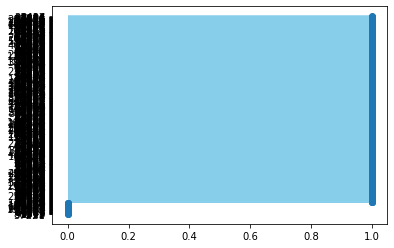

In [41]:
ordered_df = df_graph.sort_values(by='Cluster')
my_range=range(1,len(df_graph.index)+1)
plt.hlines(y=my_range, xmin=0, xmax=ordered_df['Cluster'], color='skyblue')
plt.plot(ordered_df['Cluster'], my_range, "o")
plt.yticks(my_range, ordered_df['File'])

In [60]:
[list(df_graph["Cluster"]).count(i) for i in set(df_graph["Cluster"])]

[3,
 6,
 6,
 3,
 2,
 4,
 4,
 2,
 3,
 2,
 4,
 2,
 4,
 2,
 2,
 4,
 2,
 2,
 2,
 2,
 2,
 4,
 3,
 2,
 2,
 2,
 2,
 2,
 3,
 5,
 2,
 2,
 2,
 3,
 3,
 3,
 2,
 3,
 4,
 3,
 3,
 3,
 2,
 2,
 3,
 2,
 3,
 2,
 2,
 3,
 3,
 3,
 2,
 5,
 4,
 3,
 3,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 4,
 5,
 3,
 3,
 4,
 2,
 2,
 2,
 2,
 3,
 2,
 3,
 3,
 6,
 4,
 4,
 4,
 3,
 3,
 2,
 3,
 3,
 3,
 2,
 3,
 3,
 2,
 3,
 4,
 2,
 3,
 2,
 3,
 4,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 2,
 4,
 3,
 2,
 4,
 5,
 2,
 2,
 2,
 2,
 4,
 5,
 2,
 3,
 4,
 3,
 2,
 3,
 3,
 3,
 3,
 4,
 2,
 2,
 2,
 3,
 5,
 4,
 5,
 2,
 2,
 2,
 2,
 3,
 2,
 2,
 3,
 2,
 3,
 5,
 2,
 3,
 2,
 2,
 3,
 3,
 2,
 3,
 4,
 3,
 2,
 2,
 3,
 3,
 2,
 3,
 2,
 4,
 4,
 2,
 2,
 3,
 2,
 3,
 5,
 3,
 2,
 3,
 2,
 2,
 2,
 3,
 6,
 2,
 3,
 2,
 2,
 2,
 2,
 3,
 3,
 6,
 6,
 3,
 3,
 2,
 4,
 42]

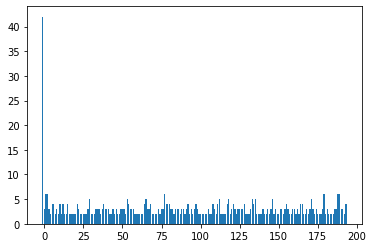

In [80]:
unique_values = [list(df_graph["Cluster"]).count(i) for i in set(df_graph["Cluster"])]
labels = list(set(df_graph["Cluster"]))
plt.bar(x = labels, height = unique_values)
plt.show()

In [78]:
labels = list(set(df_graph["Cluster"]))
numpy.array(labels).shape

(195,)

In [79]:
unique_values = [list(df_graph["Cluster"]).count(i) for i in set(df_graph["Cluster"])]
numpy.array(unique_values).shape

(195,)